# Mono sous-jacent

## Génération de chemins aléatoires

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_paths_mono(nb_paths, nb_step, sigma, r, spot, T):
    # Pas de temps
    dt = T / nb_step
    
    # Calcul en une fois des parties drift et diffusion
    W=np.random.standard_normal(size=(nb_paths, nb_step))
    
    exp_diffus_array = np.exp(sigma*np.sqrt(dt)*W)
    exp_drift = np.exp((r-sigma**2/2)*dt)
    
    # Initialisation de la matrice contenant les chemins
    paths_array = np.zeros((nb_paths, nb_step+1), np.float64)
    paths_array[:, 0] = spot # Valeur de la première colonne
    
    # Calcul des chemins
    for i in range(nb_paths):
        for j in range(nb_step):
            paths_array[i,j+1] = paths_array[i,j]*exp_drift*exp_diffus_array[i, j]
    
    return paths_array

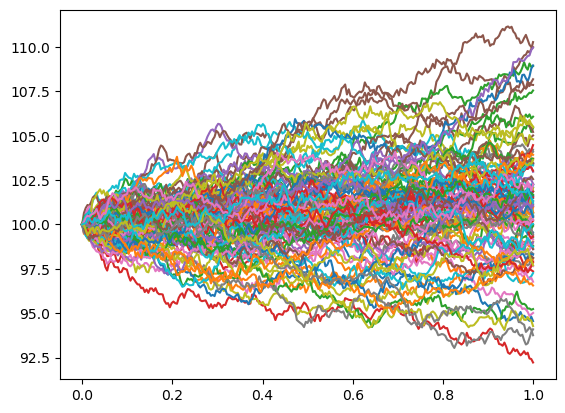

In [3]:
# Paramètres
nb_paths=100
nb_step=252
sigma=3e-2
r=1e-2
spot=100.
T=1.

# Génération des chemins
np.random.seed(123)
paths_array = generate_paths_mono(nb_paths, nb_step, sigma, r, spot, T)

# Tracés des chemins
X=[T/nb_step*i for i in range(nb_step+1)]
for traj_i in range(nb_paths):
    plt.plot(X, paths_array[traj_i])
plt.show()

## Pricing d'un call/put vanille (BS)

### Expression analytique

On commence par définir les fonctions renvoyant les prix par la formule analytique de Black-Scholes.

In [4]:
from scipy.stats import norm

def d1_funct(spot, strike, r, sigma, T):
    return (np.log(spot/strike) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
    
def d2_funct(d1, sigma, T):
    return d1 - sigma*np.sqrt(T)

def Call_BS(strike, spot, r, T, sigma):
    d1 = d1_funct(spot, strike, r, sigma, T)
    d2 = d2_funct(d1, sigma, T)
    
    return spot*norm.cdf(d1) - strike*np.exp(-r*T)*norm.cdf(d2)

def Put_BS(strike, spot, r, T, sigma):
    d1 = d1_funct(spot, strike, r, sigma, T)
    d2 = d2_funct(d1, sigma, T)
    
    return strike*np.exp(-r*T)*norm.cdf(-d2) - spot*norm.cdf(-d1)

### Calcul par Monte-Carlo

On définit les fonctions qui permettent de calculer le prix d'un Call/Put par Monte-Carlo, avec une dynamique de sous-jacent log-normal, sans technique de réduction de variance.

In [5]:
def Call_BS_MC(n, strike, spot, r, T, sigma):
    discount_factor = np.exp(-r*T)
    
    # Calcul de n valeurs du sous-jacent à la maturité T, en une fois
    X = np.random.standard_normal(size=n)
    S = spot*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*X)

    # Calcul du payoff des n simulations, de la moyenne et de l'écart-type MC des payoff
    payoff_array = np.where(S > strike, S - strike, 0) # Retourne un array qui vérifie (S_T - K)+
    mean_payoffactu, std_payoffactu = np.mean(discount_factor*payoff_array), np.std(discount_factor*payoff_array)
    
    return (mean_payoffactu, std_payoffactu)

def Put_BS_MC(n, strike, spot, r, T, sigma):
    discount_factor = np.exp(-r*T)
    
    # Calcul de la valeur à maturité du sous-jacent en une fois
    X = np.random.standard_normal(size=n)
    S = spot*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*X)

    # Calcul du payoff des n simulations, de la moyenne et de l'écart-type des payoff MC
    payoff_array = np.where(strike > S, strike - S, 0) # Retourne un array qui vérifie (K - S_T)+
    mean_payoffactu, std_payoffactu = np.mean(discount_factor*payoff_array), np.std(discount_factor*payoff_array)
    
    return (mean_payoffactu, std_payoffactu)

In [6]:
n=1000
sigma=2e-2
r=1e-4
spot=100.
strike=102
T=1.

np.random.seed(123)
price_MC, std_MC = Call_BS_MC(n, strike, spot, r, T, sigma)

price_BS = Call_BS(strike, spot, r, T, sigma)

print("Prix obtenu par MC : {} (+- {})".format(price_MC, 1.96*std_MC/np.sqrt(n))) # Seuil 5%
print("Prix théorique sous BS: {}".format(price_BS))

Prix obtenu par MC : 0.1574693310724104 (+- 0.03131116789664974)
Prix théorique sous BS: 0.17309409382861674


In [7]:
n=1000
sigma=2e-2
r=1e-4
spot=100.
strike=98
T=1.

np.random.seed(123)
price_MC, std_MC = Put_BS_MC(n, strike, spot, r, T, sigma)[0:2]

price_BS = Put_BS(strike, spot, r, T, sigma)

print("Prix obtenu par MC : {} (+- {})".format(price_MC, 1.96*std_MC/np.sqrt(n))) # Seuil 5%
print("Prix théorique sous BS: {}".format(price_BS))

Prix obtenu par MC : 0.17860192241077913 (+- 0.0328919629964945)
Prix théorique sous BS: 0.160243346766757


### Calcul par Monte-Carlo avec réduction de variance

On définit désormais la fonction prix d'un call par Monte-Carlo avec variable de contrôle afin de réduire la variance Monte-Carlo (pour $\frac{K}{S_0}$ pas trop grand par rapport à $1$).

Par la parité call/put, $C_{t=0} = P_{t=0} + S_0 - Ke^{-rT}$

In [8]:
def Call_BS_MC_v2(n, strike, spot, r, T, sigma):
    discount_factor = np.exp(-r*T)

    mean_put, std_put = Put_BS_MC(n, strike, spot, r, T, sigma)

    return (mean_put + spot - strike*discount_factor, std_put)

In [9]:
n=10000
sigma=0.3
r=0.05
spot=100.
strike=105
T=1.

np.random.seed(123)
price_MC, std_MC = Call_BS_MC_v2(n, strike, spot, r, T, sigma)
price_MC_v1, std_MC_v1 = Call_BS_MC(n, strike, spot, r, T, sigma)

price_BS = Call_BS(strike, spot, r, T, sigma)

print("Prix obtenu par MC avec réduction de variance : {} (+- {})"
      .format(price_MC, 1.96*std_MC/np.sqrt(n))) # Proba à 95%

print("Prix obtenu par MC : {} (+- {})".format(price_MC_v1, 1.96*std_MC_v1/np.sqrt(n))) # Proba à 95%

print("Prix théorique sous BS: {}".format(price_BS))



Prix obtenu par MC avec réduction de variance : 11.849603590294166 (+- 0.2867835719599274)
Prix obtenu par MC : 12.247711051024128 (+- 0.41905445532687124)
Prix théorique sous BS: 11.976881462184025


## Pricing d'un autocall

On considère un autocall avec les caractéristiques suivantes (inspiré du livre de M. Bouzoubaa, <i>Exotic Options and Hybrids </i>) :

- Durée de vie maximale : $T$

- $n$ dates d'observation  : $0 < t_1 < ... < t_n = T$

- Octroie un coupon $N.C$ ($N$ : nominal, $C$ : pourcent de nominal) si:
    - le sous-jacent est au-dessus du seuil $K$ à la date d'observation $t_i$
    - <b> et </b> le niveau du sous-jacent n'a jamais été observé au-dessus d'un seuil $B$.

- Rembourse le notionnel au temps $t_i$ et désactive le produit si:
    - la valeur du sous-jacent en $t_i$ est observé au-dessus de $B$
    - <b> ou </b> le produit atteint sa durée de vie maximale.

$Coupon(t_i) = NC\mathbb{1}_{\{S_{t_i} > K\}} \mathbb{1}_{\{max_{k = 1, ..., i}S_{t_k} < B\}}$

$Rebate(t_i) = N(\mathbb{1}_{\{S_{t_i} > B\}} \mathbb{1}_{\{max_{k = 1, ..., i-1}S_{t_k} < B\}} + \mathbb{1}_{\{max_{k = 1, ..., n} S_{t_k} < B\}})$

In [10]:
def autocall_mono(K, B, C, N, T, spot, r, sigma, nb_observ, nb_paths):
    """
        Pricer d'autocall par Monte-Carlo sous Black-Scholes, non-optimisé
        ----------
        Paramètres :
        
        K : Strike
        B : Seuil de désactivation du produit
        C : Coupon (en % de N)
        N : Nominal remboursé
        T : Durée de vie maximale de l'autocall (année(s))
        spot : Valeur spot du sous-jacent
        r : taux d'intérêt sans risque
        sigma : volatilité du sous-jacent
        nb_observ : nombre total d'observations du prix
        nb_paths : nombre de trajectoires à simuler
        
        Retour :
        Couple (a,b), où a : moyenne des payoffs actu
                         b : écart-type des payoffs actu
        ----------
    """
    
    dt = T/nb_observ # pas de temps
    total_list = [] # liste des payoff pour toutes les trajectoires
    paths_array = generate_paths_mono(nb_paths, nb_observ, sigma, r, spot, T) # trajectoires (une par ligne)
    
    for i in range(nb_paths):
        j = 1
        t = dt
        total = 0
        while True:
            S = paths_array[i, j]
            
            # Détachement d'un coupon si S au-dessus du strike et en-dessous de la barrière désactivante
            if (S > K) and (S < B):
                total += N*C*np.exp(-r*t)
            
            # Désactivation du produit si S au-dessus de la barrière désactivante ou si le produit atteint sa durée de vie max
            if (S > B) or (j == nb_observ):
                total += N*np.exp(-r*t)
                total_list.append(total)
                break
                 
            t = t + dt
            j = j + 1
    
    return np.mean(total_list), np.std(total_list)

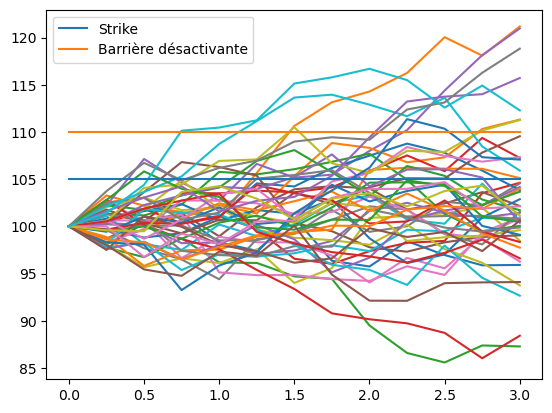

In [11]:
# Paramètres des chemins
nb_paths=50
nb_observ, T = 12, 3. # 12 observations en 3 ans i.e. 1 observation tous les trois mois
sigma=4e-2
r=1e-2
spot=100.

# Strike et barrière désactivante de l'autocall
K = 105
B = 110

# Génération des chemins
np.random.seed(123)
paths_array = generate_paths_mono(nb_paths, nb_observ, sigma, r, spot, T)

# Tracés des chemins
X=[T/nb_observ*i for i in range(nb_observ+1)]
for traj_i in range(nb_paths):
    plt.plot(X, paths_array[traj_i])
    
plt.plot(X, [K for x in range(len(X))], label="Strike")
plt.plot(X, [B for x in range(len(X))], label="Barrière désactivante")
plt.legend(loc="upper left")
plt.show()

In [12]:
N = 1 # Nominal remboursé
C = 10e-2 # Coupon

nb_paths=10000
nb_observ, T = 12, 3. # 12 observations en 3 ans i.e. 1 observation tous les trois mois
sigma=2e-2
r=1e-2
spot=100.

# Strike et barrière désactivante de l'autocall
K = 110
B = 120

np.random.seed(123)
price_MC, std_MC = autocall_mono(K, B, C, N, T, spot, r, sigma, nb_observ, nb_paths)
print("Prix de l'autocall : {} (+- {})".format(price_MC, 1.96*std_MC/np.sqrt(nb_paths)))

Prix de l'autocall : 0.9778053002238124 (+- 0.000894192013352051)


Le prix de l'autocall ainsi calculé est de 97.78% < 100%.

Si l'on ignore la commission prise par le revendeur de l'autocall, <b> il nous reste un peu de capital qu'on peut allouer dans un produit en plus de l'autocall, par exemple une option, pour rendre le produit plus attractif au yeux du client.</b>